<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-cnn-cancer-detection/blob/main/cnn-cancer-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer detection using CNN

## Introduction

In [1]:
from google.colab import files
from collections import Counter
import os
import shutil
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.utils import to_categorical


In [3]:
# get set up with kaggle
files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# note to self: '_kaggle' file is located in dtsa5511 folder

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
# get data from kaggle
!kaggle competitions download -c histopathologic-cancer-detection > /dev/null
!unzip histopathologic-cancer-detection.zip -d ./data > /dev/null

100% 6.31G/6.31G [00:37<00:00, 181MB/s]


### The Problem

Briefly describe the challenge problem and NLP.

The purpose of this project is to participate in the (now closed) Kaggle competition [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection) by creating an algorithm to classify metastatic cancer cells in small images taken from larger digital pathology scans. The Kaggle site describes this data as
" a slightly modified version of the [PatchCamelyon (PCam) benchmark dataset](https://github.com/basveeling/pcam) (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates)."

Identification of cancerous cells by a human is time consuming and expensive. Using ML models as a tool to assist a human in flagging positive classes can reduce the amount of time it would take for a patient to receive treatment, and care providers can focus more of their time on more complicated cases rather than screening out large numbers of negative classes.

### The Data

Describe the size, dimension, structure, etc., of the data.

In [5]:
file_path = './data/train_labels.csv'
df = pd.read_csv(file_path)
df.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


## EDA

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

In [7]:
null_count = df.isnull().sum()
null_count

,0
id,0
label,0


No cleaning is necessary, but this is a very large dataset. I'll work with a subset when creating a model.


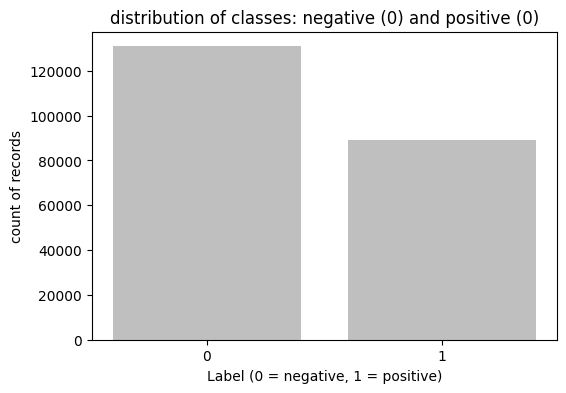

In [8]:
# plot dist
labels, counts = zip(*Counter(df['label']).items())
plt.figure(figsize = (6, 4))
plt.bar(labels, counts, color=['grey', 'grey'], alpha = 0.5)
plt.xlabel('Label (0 = negative, 1 = positive)')
plt.ylabel('count of records')
plt.title('distribution of classes: negative (0) and positive (0)')
plt.xticks(labels)
plt.show()

Classes are imbalanced, which could introduce bias in our model. I'll take a balanced sampple.

In [9]:
# ref 1.
# sample a balance of classes
df_neg = df[df['label'] == 0].sample(n = 10000, random_state = 5511)
df_pos = df[df['label'] == 1].sample(n = 10000, random_state = 5511)
df_sample = pd.concat([df_neg, df_pos])
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 102923 to 22962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.8+ KB


In [10]:
# add column for image file path
df_sample['path'] = df_sample['id'].apply(lambda x: os.path.join('./data/train', str(x) + '.tif'))
df_sample.head(3)

,id,label,path
102923,c49aa322df7d43eedf267bbd31292c6fb9974418,0,./data/train/c49aa322df7d43eedf267bbd31292c6fb...
81742,e0b86d66a79ee5fa0c1bdfef8f4fcc414244b63c,0,./data/train/e0b86d66a79ee5fa0c1bdfef8f4fcc414...
124044,7f2dfc21777d22d881f97f7ed29d6350c7bd25f1,0,./data/train/7f2dfc21777d22d881f97f7ed29d6350c...


Lets have a look at what these images look like:

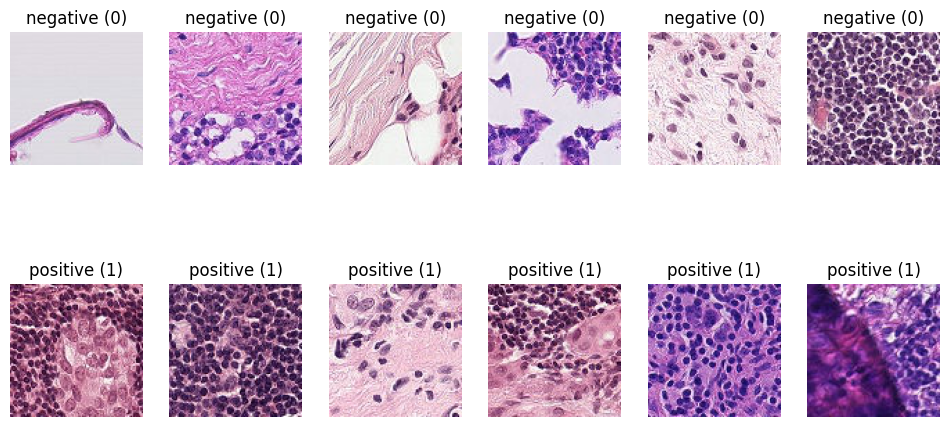

In [11]:
# enter number img to disp from each class
num_images = 6

plt.figure(figsize = (12, 6))

# plot classes
for i in range(num_images):
    # neg
    image_neg = plt.imread(df_sample[df_sample['label'] == 0]['path'].iloc[i])
    plt.subplot(2, 6, i + 1)
    plt.imshow(image_neg)
    plt.axis('off')
    plt.title('negative (0)')

    # pos
    image_pos = plt.imread(df_sample[df_sample['label'] == 1]['path'].iloc[i])
    plt.subplot(2, 6, 6 + i + 1)
    plt.imshow(image_pos)
    plt.axis('off')
    plt.title('positive (1)')

plt.show()

In [12]:
unique_dimensions = set()
random_indices = np.random.randint(0, len(df_sample), 1000)
for index in random_indices:
    image = io.imread(df_sample["path"].iloc[index])
    image_height, image_width, image_channels = image.shape
    unique_dimensions.add((image_height, image_width, image_channels))

print(f"Unique dimension: {unique_dimensions}")
print(f"Image Height: {image_height} pixels")
print(f"Image Width: {image_width} pixels")
print(f"Number of Channels (Depth): {image_channels}")

Unique dimension: {(96, 96, 3)}
Image Height: 96 pixels
Image Width: 96 pixels
Number of Channels (Depth): 3


In [13]:
# load and standardize images
X = np.array([plt.imread(path) for path in df_sample['path']])  # Load images
X = X / 255.0  # Normalize pixel values

In [14]:
# Labels
y = df_sample['label'].values
y = to_categorical(y)  # One-hot encode labels

In [15]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5511)

In [16]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

In [17]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=32)

Epoch 1/5
500/500 [==============================] - 213s 426ms/step - loss: 0.5159 - accuracy: 0.7594 - val_loss: 0.4670 - val_accuracy: 0.7885
Epoch 2/5
500/500 [==============================] - 214s 428ms/step - loss: 0.4775 - accuracy: 0.7813 - val_loss: 0.4908 - val_accuracy: 0.7697
Epoch 3/5
500/500 [==============================] - 211s 421ms/step - loss: 0.4549 - accuracy: 0.7961 - val_loss: 0.4406 - val_accuracy: 0.8025
Epoch 4/5
500/500 [==============================] - 209s 418ms/step - loss: 0.4152 - accuracy: 0.8204 - val_loss: 0.4310 - val_accuracy: 0.8083
Epoch 5/5
500/500 [==============================] - 214s 429ms/step - loss: 0.3725 - accuracy: 0.8394 - val_loss: 0.4147 - val_accuracy: 0.8227


In [21]:
histroy_df = pd.DataFrame(history.history)
histroy_df

,loss,accuracy,val_loss,val_accuracy
0,0.515852,0.759375,0.466995,0.78850
1,0.477534,0.781313,0.490808,0.76975
2,0.454862,0.796063,0.440556,0.80250
3,0.415241,0.820437,0.430981,0.80825
4,0.372533,0.839437,0.414696,0.82275


In [ ]:
# split sample data
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(df_sample['path'], df_sample['label'], test_size = 0.2, random_state = 5511)



In [ ]:
# Create directory called train_data and copy the training data into it
train_dir = "train_data"
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)
os.makedirs(os.path.join(train_dir, "0"))
os.makedirs(os.path.join(train_dir, "1"))
for file_path, label in zip(train_file_paths, train_labels):
    name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(train_dir, "0", name))
    else:
        shutil.copy2(file_path, os.path.join(train_dir, "1", name))

# Create directory called test_data and copy the test data into it
test_dir = "test_data"
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)
os.makedirs(os.path.join(test_dir, "0"))
os.makedirs(os.path.join(test_dir, "1"))
for file_path, label in zip(test_file_paths, test_labels):
    name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(test_dir, "0", name))
    else:
        shutil.copy2(file_path, os.path.join(test_dir, "1", name))

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(image_width, image_height),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(image_width, image_height),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
    seed=42
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [ ]:
# Hyperparameters
learning_rate = 0.001
optimizer = RMSprop(learning_rate=learning_rate)
training_epochs = 10
batch_size = 32
dropout_rate = 0.5

model1 = Sequential()
pool_size = (3, 3)
filter_size = (3, 3)

# Convolutional layers
model1.add(Conv2D(16, filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))
model1.add(Conv2D(16, filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=pool_size))

model1.add(Conv2D(32, filter_size, activation='relu'))
model1.add(Conv2D(32, filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=pool_size))

model1.add(Conv2D(64, filter_size, activation='relu'))
model1.add(Conv2D(64, filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=pool_size))

# Convert to 1D vector
model1.add(Flatten())

# Classification layers
model1.add(Dense(64, activation='sigmoid'))
model1.add(Dropout(dropout_rate))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
train_steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps_per_epoch=test_generator.n//test_generator.batch_size
history1 = model1.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=training_epochs,
    validation_data=test_generator,
    validation_steps=validation_steps_per_epoch
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 112ms/step - accuracy: 0.9970 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 3.2158e-05
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 33us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
 47/500 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 1.0000 - loss: 4.4041e-05

KeyboardInterrupt: 

In [ ]:
# Hyperparameters
learning_rate = 0.01
optimizer = SGD(learning_rate=learning_rate)
training_epochs = 10
batch_size = 32
dropout_rate = 0.25

model2 = Sequential()
pool_size = (3, 3)
filter_size = (3, 3)

# Convolutional layers
model2.add(Conv2D(16, filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))
model2.add(Conv2D(16, filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=pool_size))

model2.add(Conv2D(32, filter_size, activation='relu'))
model2.add(Conv2D(32, filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=pool_size))

model2.add(Conv2D(64, filter_size, activation='relu'))
model2.add(Conv2D(64, filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=pool_size))

# Convert to 1D vector
model2.add(Flatten())

# Classification layers
model2.add(Dense(64, activation='sigmoid'))
model2.add(Dropout(dropout_rate))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
train_steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps_per_epoch=test_generator.n//test_generator.batch_size
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=training_epochs,
    validation_data=test_generator,
    validation_steps=validation_steps_per_epoch
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 110ms/step - accuracy: 0.9901 - loss: 0.1044 - val_accuracy: 1.0000 - val_loss: 0.0134
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 110ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 109ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 109ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 28us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - accuracy: 1.0000 - loss: 0.0019 - val_ac

## Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

## Results and Analysis

### Kaggle competition ranking

Submission file .csv format:

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
etc.

## Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

## References

1. [This Kaggle notebook](https://www.kaggle.com/code/arcotgautham/msds-histopathologic-cancer-detection-cnn-model) for guidance on getting the data from Kaggle and getting a smaller sample of it.